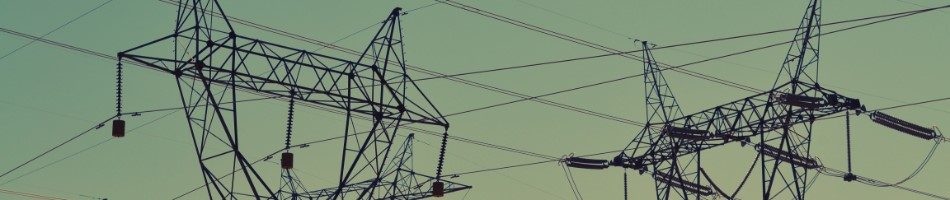

**ABOUT THE DATA**

Data Set Information:

Context: Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).
Notes:
1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt). Global active power is the power consumed by appliances other than the appliances mapped to Sub Meters. Global active power is the real power consumption i.e. the power consumed by electrical appliances other than the sub metered appliances.It is basically called wattfull power.

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt). Global reactive power is the power which bounces back and froth without any usage or leakage. It is the imaginary power consumption. It is basically called wattless power.

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere). Intensity is magnitude of the power consumed. Also called as strength of current.

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.




**APPROACH**

* Conevrting the data to an hour by hour format rather than a 10 minute bases
* Cleaning the Data
* Perform analysis and EDA to get our data Insights 
* Perform Time series forecasting using LSTM 

In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


**IMPORTING MODULES AND DATA**

In [61]:
# Importing required modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# importing data
df = pd.read_csv('../input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';', 
                 parse_dates={'Datetime' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?']) #, index_col='Datetime'

###################################
# 1) Note that data include 'nan' and '?' as a string. I converted both to numpy nan in importing stage (above) and treated both of them the same.
# 2) I merged two columns 'Date' and 'Time' to 'dt'.
# 3) I also converted in the above, the data to time-series type, by taking index to be the time.
##################################

df.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [62]:
print(len(df))
df.info()
# Resampling by hours
df_hour = df[df.Datetime.dt.minute==0]
# Setting Datetime as Index
df_hour = df_hour.set_index(['Datetime'])
print(len(df_hour))
df_hour.info()

2075259
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
34588
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34588 entries, 2006-12-16 18:00:00 to 2010-11-26 21:00:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34152 non-null  float64
 1   Global_reactive_power  34152 non-null  float64
 2   Voltage                3415

In [63]:
df_hour.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 18:00:00,2.790,0.180,237.52,11.8,0.0,0.0,18.0
2006-12-16 19:00:00,4.070,0.088,231.99,17.4,0.0,1.0,17.0
2006-12-16 20:00:00,3.206,0.078,232.43,13.8,0.0,0.0,16.0
2006-12-16 21:00:00,3.314,0.072,236.76,14.0,0.0,0.0,17.0
2006-12-16 22:00:00,3.464,0.170,236.03,14.6,0.0,1.0,17.0


**DATA CLEANING**

In [64]:
df_hour.shape

(34588, 7)

In [65]:
print(df_hour.isnull().sum())

Global_active_power      436
Global_reactive_power    436
Voltage                  436
Global_intensity         436
Sub_metering_1           436
Sub_metering_2           436
Sub_metering_3           436
dtype: int64


In [66]:
# Visualizing Null values
df_null = df_hour.loc[pd.isnull(df_hour).any(axis=1)]
df_null.tail(15)
df_null.head(15)
#  As we can see from the table below most of the null value columns are entirely empty, So we will be dropping these rows

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2007-04-28 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# dropping the empty rows
df_hour = df_hour.dropna()
print(len(df_hour))
print(df_hour.isnull().sum())

34152
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [68]:
df_hour.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34152.0,1.097489,1.062296,0.078,0.308,0.606,1.536,8.758
Global_reactive_power,34152.0,0.123538,0.113487,0.000,0.048,0.100,0.194,1.218
Voltage,34152.0,240.716634,3.237554,225.540,238.860,240.880,242.790,253.170
Global_intensity,34152.0,4.654767,4.469054,0.200,1.400,2.600,6.400,37.600
Sub_metering_1,34152.0,1.107900,6.115999,0.000,0.000,0.000,0.000,80.000
Sub_metering_2,34152.0,1.325135,5.919362,0.000,0.000,0.000,1.000,79.000
Sub_metering_3,34152.0,6.506032,8.461815,0.000,0.000,1.000,17.000,31.000


In [69]:
# Visualizing Some max values
df_hour[df_hour['Global_active_power']==8.758]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2009-01-10 20:00:00,8.758,0.062,232.2,37.6,36.0,71.0,16.0


In [70]:
df_hour[df_hour['Global_reactive_power']==1.218]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2009-07-19 11:00:00,2.586,1.218,238.57,12.2,0.0,0.0,12.0


In [71]:
df_hour[df_hour['Sub_metering_1']==80]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2009-01-24 13:00:00,8.508,0.252,235.52,36.0,80.0,36.0,18.0


In [72]:
df_hour[df_hour['Sub_metering_2']==79]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2010-02-07 15:00:00,5.108,0.112,244.52,20.8,0.0,79.0,1.0


In [73]:
df_hour[df_hour['Sub_metering_3']==31]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2009-06-29 23:00:00,2.128,0.268,241.96,8.8,2.0,0.0,31.0
2009-07-03 19:00:00,2.044,0.242,241.60,8.4,0.0,0.0,31.0
2009-07-21 21:00:00,2.086,0.360,241.98,8.6,0.0,1.0,31.0
2009-08-22 10:00:00,2.086,0.152,242.01,8.6,0.0,1.0,31.0
2010-07-05 16:00:00,2.138,0.422,241.51,9.0,0.0,1.0,31.0


These values can be used for future reference, for more data cleaning purposes 

**EDA AND DATA VISUALIZATION**

Approach :

* Visualize some features to see their seasonality over time 
* Plot some correlation plots between our target variable and some featureset
* Document some vvisual insights

In [74]:
# created n hour column to visualize the features at an hourly rate
df_hour['hour'] = df_hour.index.strftime('%H')
df_hour['month'] = df_hour.index.strftime('%m')

df_hour.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,month
Datetime,,,,,,,,,
2006-12-16 18:00:00,2.790,0.180,237.52,11.8,0.0,0.0,18.0,18,12
2006-12-16 19:00:00,4.070,0.088,231.99,17.4,0.0,1.0,17.0,19,12
2006-12-16 20:00:00,3.206,0.078,232.43,13.8,0.0,0.0,16.0,20,12
2006-12-16 21:00:00,3.314,0.072,236.76,14.0,0.0,0.0,17.0,21,12
2006-12-16 22:00:00,3.464,0.170,236.03,14.6,0.0,1.0,17.0,22,12


In [75]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34152 entries, 2006-12-16 18:00:00 to 2010-11-26 21:00:00
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34152 non-null  float64
 1   Global_reactive_power  34152 non-null  float64
 2   Voltage                34152 non-null  float64
 3   Global_intensity       34152 non-null  float64
 4   Sub_metering_1         34152 non-null  float64
 5   Sub_metering_2         34152 non-null  float64
 6   Sub_metering_3         34152 non-null  float64
 7   hour                   34152 non-null  object 
 8   month                  34152 non-null  object 
dtypes: float64(7), object(2)
memory usage: 2.6+ MB


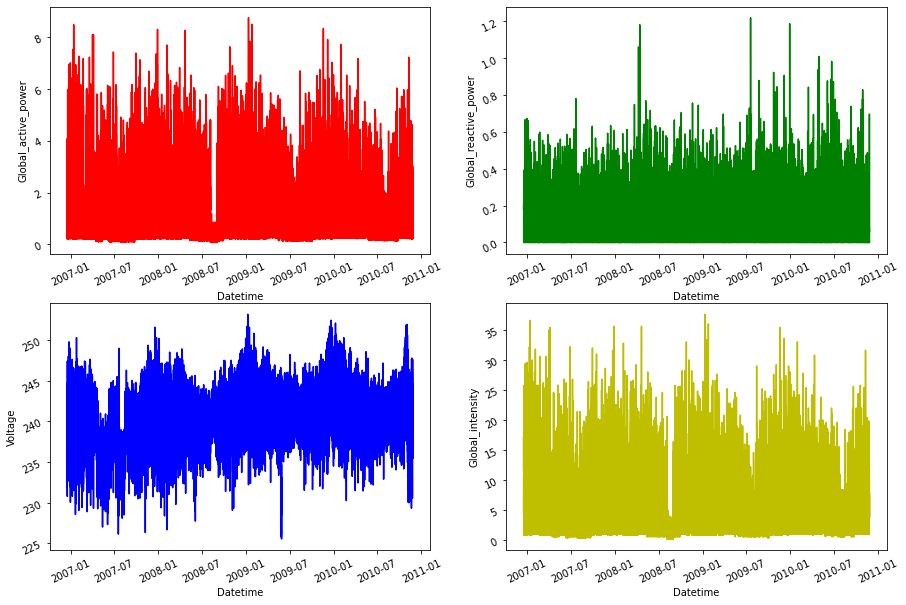

In [76]:
fig,ax =  plt.subplots( 2, 2,
                       figsize = ( 15, 10))
  
sns.lineplot( x = df_hour.index, y = "Global_active_power", 
             color = 'r', data = df_hour, 
             ax = ax[0][0])
ax[0][0].tick_params(labelrotation = 25)

sns.lineplot( x = df_hour.index, y = "Global_reactive_power", 
             color = 'g', data = df_hour,
             ax = ax[0][1])
ax[0][1].tick_params(labelrotation = 25)

sns.lineplot(x = df_hour.index, y = "Voltage", 
             color = 'b', data = df_hour,
             ax = ax[1][0])
ax[1][0].tick_params(labelrotation = 25)
  
sns.lineplot(x = df_hour.index, y = "Global_intensity", 
             color = 'y', data = df_hour, 
             ax = ax[1][1])
ax[1][1].tick_params(labelrotation = 25)

The graph above sbove plot shows the sesonality of the data, this plot will be futher expanded on using our next plots, in order to visualize our seasonality better

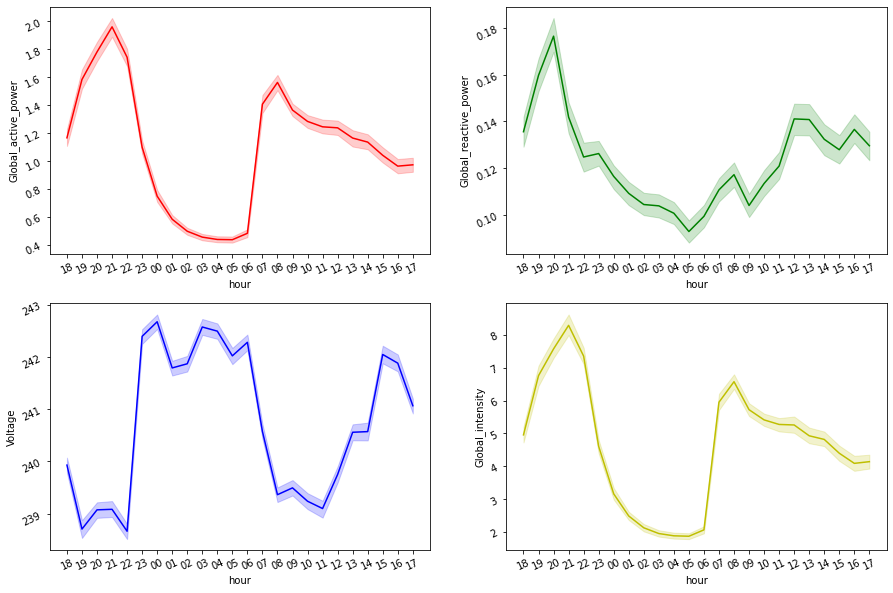

In [77]:
# Visualizations across hours 
fig,ax =  plt.subplots( 2, 2,
                       figsize = ( 15, 10))

sns.lineplot(x=df_hour['hour'], y=df_hour['Global_active_power'], ax = ax[0][0], color='r')
ax[0][0].tick_params(labelrotation = 25)

sns.lineplot(x=df_hour['hour'], y=df_hour['Global_reactive_power'], ax = ax[0][1], color='g')
ax[0][1].tick_params(labelrotation = 25)

sns.lineplot(x=df_hour['hour'], y=df_hour['Voltage'], ax = ax[1][0], color='b')
ax[1][0].tick_params(labelrotation = 25)

sns.lineplot(x=df_hour['hour'], y=df_hour['Global_intensity'], ax = ax[1][1], color='y')
ax[1][1].tick_params(labelrotation = 25)
plt.show()

This plot is similar to the previous plot but is  done based on an hourly basis in our to visualize our seasonality.
We can observe a majority of the plots having two peaks. 
A major takeaway from the plots are the actual household usage (Global active Power), which has two peaks and majorly between 19:00 - 21:00 and 7:00 - 9:00

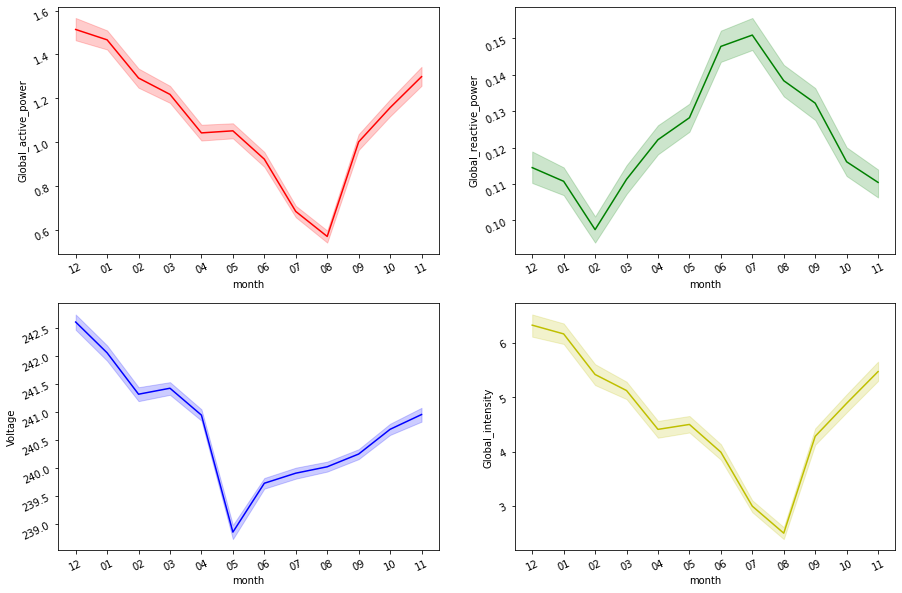

In [78]:
# Visualization across months
fig,ax =  plt.subplots( 2, 2,
                       figsize = ( 15, 10))

sns.lineplot(x=df_hour['month'], y=df_hour['Global_active_power'], ax = ax[0][0], color='r')
ax[0][0].tick_params(labelrotation = 25)

sns.lineplot(x=df_hour['month'], y=df_hour['Global_reactive_power'], ax = ax[0][1], color='g')
ax[0][1].tick_params(labelrotation = 25)

sns.lineplot(x=df_hour['month'], y=df_hour['Voltage'], ax = ax[1][0], color='b')
ax[1][0].tick_params(labelrotation = 25)

sns.lineplot(x=df_hour['month'], y=df_hour['Global_intensity'], ax = ax[1][1], color='y')
ax[1][1].tick_params(labelrotation = 25)
plt.show()

The plots show some imilarities when displayed across months, there is a very sharp spike downwards on all the plots, which can understood as a response to the varying changes in season, this is especially true for global active power, which drops during the summer and rises in winter season

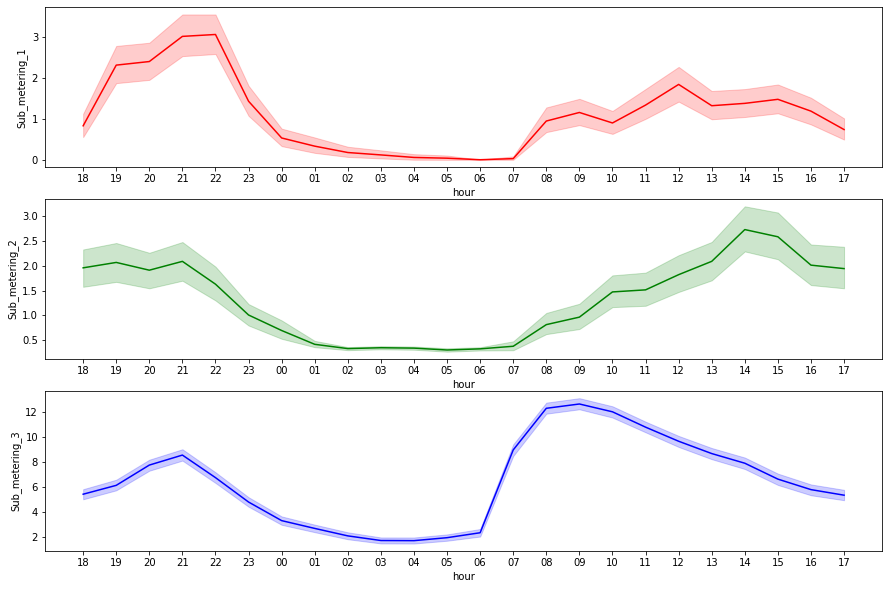

In [79]:
# Visualizations across Hours 
fig,ax =  plt.subplots( 3,1,
                       figsize = ( 15, 10))

sns.lineplot( x = 'hour', y = "Sub_metering_1", 
             color = 'r', data = df_hour, 
             ax = ax[0] )

sns.lineplot( x = 'hour', y = "Sub_metering_2", 
             color = 'g', data = df_hour,
             ax = ax[1])

sns.lineplot(x = 'hour', y = "Sub_metering_3", 
             color = 'b', data = df_hour,
             ax = ax[2])
plt.show()

The plot above shows the energy distribution per hour for each sub meter.
A quick thing to nte is that the submeter(1) for kitchen increases from 18:00 - 11:00 before experiencing a sharp decline and increasing by 7:00.
The submeter(2) for Laundry also experiences two peaks, with one in the early hours of the evening and the higher one in the latter part of the day.
The last submeter(3) for Air conditiong and water heater also experiences two peaks, with the lower peak in the early evening (assumed mostly for water heater) and a higher peak from the early hours of the morning(assumed entails mostly a combination of the water heater and the Air conditioning) 

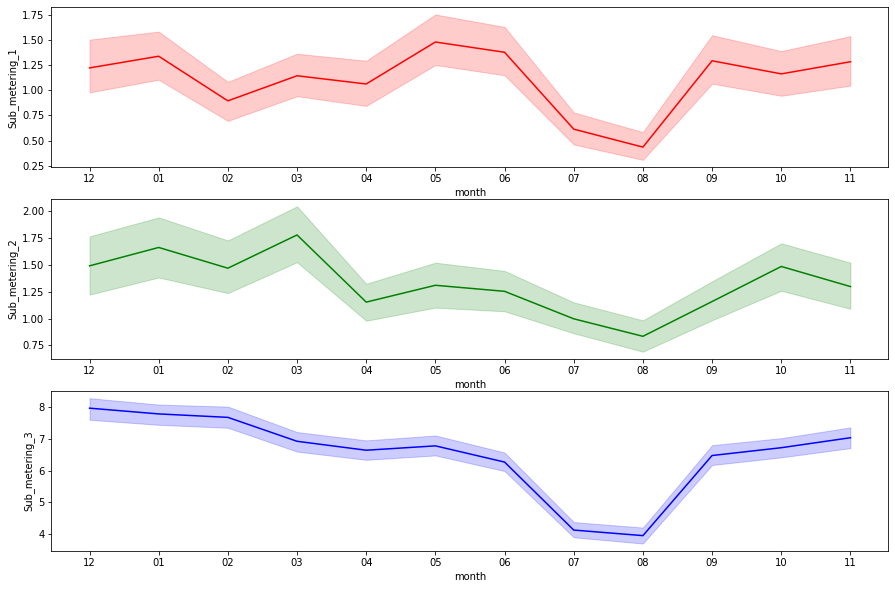

In [80]:
# Plots across Months
fig,ax =  plt.subplots( 3,1,
                       figsize = (15, 10))

sns.lineplot( x = 'month', y = "Sub_metering_1", 
             color = 'r', data = df_hour, 
             ax = ax[0] )

sns.lineplot( x = 'month', y = "Sub_metering_2", 
             color = 'g', data = df_hour,
             ax = ax[1])

sns.lineplot(x = 'month', y = "Sub_metering_3", 
             color = 'b', data = df_hour,
             ax = ax[2])
plt.show()

The plots above also show a similarity as there is a spike downward during the summer and pek during the colder seasons

In [81]:
df_hour.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,month
Datetime,,,,,,,,,
2006-12-16 18:00:00,2.79,0.180,237.52,11.8,0.0,0.0,18.0,18,12
2006-12-16 19:00:00,4.07,0.088,231.99,17.4,0.0,1.0,17.0,19,12


In [82]:
df_hour['Total_sub_metering'] = df_hour['Sub_metering_1'] + df_hour['Sub_metering_2'] + df_hour['Sub_metering_3']
df_hour.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,month,Total_sub_metering
Datetime,,,,,,,,,,
2006-12-16 18:00:00,2.790,0.180,237.52,11.8,0.0,0.0,18.0,18,12,18.0
2006-12-16 19:00:00,4.070,0.088,231.99,17.4,0.0,1.0,17.0,19,12,18.0
2006-12-16 20:00:00,3.206,0.078,232.43,13.8,0.0,0.0,16.0,20,12,16.0
2006-12-16 21:00:00,3.314,0.072,236.76,14.0,0.0,0.0,17.0,21,12,17.0
2006-12-16 22:00:00,3.464,0.170,236.03,14.6,0.0,1.0,17.0,22,12,18.0


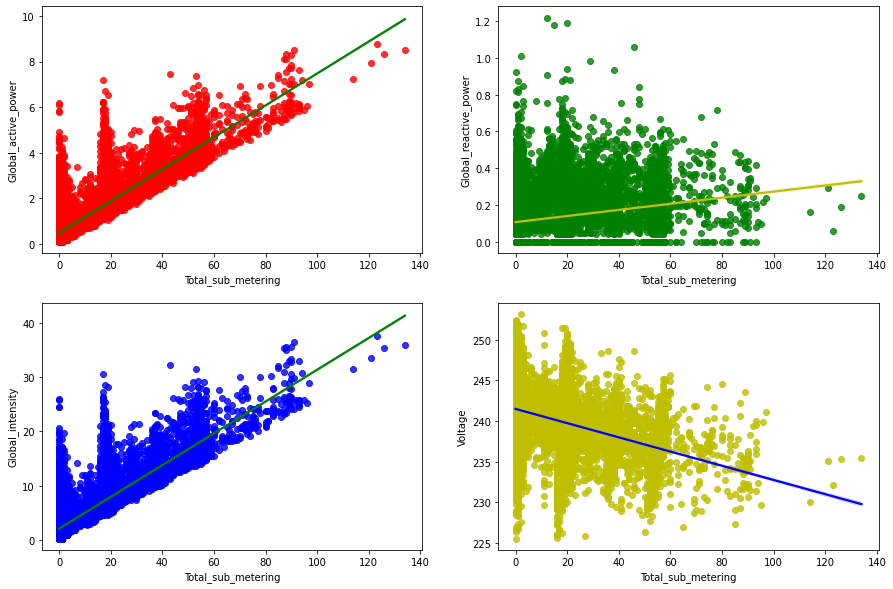

In [83]:
fig,ax =  plt.subplots( 2,2,
                       figsize = ( 15, 10))

sns.regplot( x = 'Total_sub_metering', y = "Global_active_power", 
             color = 'r', data = df_hour, line_kws={'color': 'g'},
             ax = ax[0][0] )

sns.regplot( x = 'Total_sub_metering', y = "Global_reactive_power", 
             color = 'g', data = df_hour, line_kws={'color': 'y'},
             ax = ax[0][1])

sns.regplot(x = 'Total_sub_metering', y = "Global_intensity", 
             color = 'b', data = df_hour, line_kws={'color': 'g'},
             ax = ax[1][0])

sns.regplot(x = 'Total_sub_metering', y = "Voltage", 
             color = 'y', data = df_hour, line_kws={'color': 'b'},
             ax = ax[1][1])
plt.show()

The plot above shows the correlation of some festuresets in relation to the total sub meter readings, the Global active power and the Global intensity share a similar relationship with the total sub metering showing a positive correlation.
The other plots show correlations but not as high as the previously mentioned features, but can be seen visually on their individual plots

In [84]:
df_hour.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,month,Total_sub_metering
Datetime,,,,,,,,,,
2006-12-16 18:00:00,2.79,0.180,237.52,11.8,0.0,0.0,18.0,18,12,18.0
2006-12-16 19:00:00,4.07,0.088,231.99,17.4,0.0,1.0,17.0,19,12,18.0


In [85]:
df_hour = df_hour.drop(['Total_sub_metering', 'hour', 'month'], axis=1)
df_hour.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 18:00:00,2.79,0.180,237.52,11.8,0.0,0.0,18.0
2006-12-16 19:00:00,4.07,0.088,231.99,17.4,0.0,1.0,17.0


In [86]:
df_hour.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247029,-0.403271,0.998878,0.473477,0.439703,0.639893
Global_reactive_power,0.247029,1.000000,-0.110569,0.266094,0.129082,0.141363,0.092856
Voltage,-0.403271,-0.110569,1.000000,-0.414890,-0.199118,-0.162585,-0.270334
Global_intensity,0.998878,0.266094,-0.414890,1.000000,0.478781,0.444861,0.627771
Sub_metering_1,0.473477,0.129082,-0.199118,0.478781,1.000000,0.047073,0.096693
Sub_metering_2,0.439703,0.141363,-0.162585,0.444861,0.047073,1.000000,0.080226
Sub_metering_3,0.639893,0.092856,-0.270334,0.627771,0.096693,0.080226,1.000000


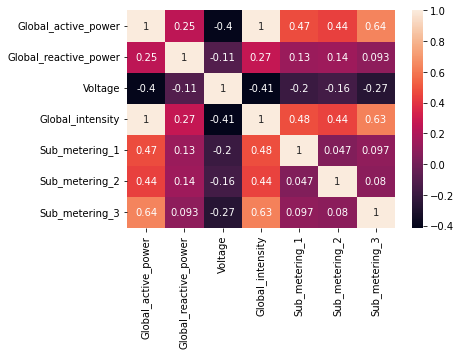

In [87]:
sns.heatmap(df_hour.corr(), annot=True)
plt.show()

**DATA SPLITTING AND PREPARATION**

Approach:
Data Window

I will be using the LSTM nueral network for our time series prediction because:

* it is best suited for large data,
* time-seriers, and
* sequential problem.

Therefore we will have to create a data window for our LSTM model.Our Target will be to predict the Global_active_power

The main features of the window are:

* The width (number of time steps) of the input and label windows.
* The time offset between them.
* Which features are used as inputs, labels, or both.

Split Our data

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

* It ensures that chopping the data into windows of consecutive samples is still possible.
* It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. The validation and test sets ensure that you get (somewhat) honest metrics.

In [88]:
df_hour.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 18:00:00,2.79,0.180,237.52,11.8,0.0,0.0,18.0
2006-12-16 19:00:00,4.07,0.088,231.99,17.4,0.0,1.0,17.0


In [89]:
# Get the number ofcolumns and there index
column_indices = {name: i for i, name in enumerate(df_hour.columns)}
print(column_indices)

# Splitting our Data
n = len(df_hour)
train_df = df_hour[0:int(n*0.7)]
val_df = df_hour[int(n*0.7):int(n*0.9)]
test_df = df_hour[int(n*0.9):]

# Get the number of columns
print(train_df.shape, val_df.shape, test_df.shape)

{'Global_active_power': 0, 'Global_reactive_power': 1, 'Voltage': 2, 'Global_intensity': 3, 'Sub_metering_1': 4, 'Sub_metering_2': 5, 'Sub_metering_3': 6}
(23906, 7) (6830, 7) (3416, 7)


In [90]:
# Data Normalization
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_df = scaler.fit_transform(train_df)
# val_df = scaler.transform(val_df)
# test_df = scaler.transform(test_df)
# print(train_df[0], train_df.shape)
# print(val_df[0], val_df.shape)
# print(test_df[0], test_df.shape)

In [91]:
# Function to create sliding Window
def create_data_window(dataset, time_step):
	X, y = [], []
	for i in range(len(dataset)):
		# find the end of this pattern
		end_ix = i + time_step
		# check if we are beyond the dataset
		if end_ix > len(dataset):
			break
		# gather input and output parts of the pattern
        # We used indexing based on the location of our target variable in our dataframe
		seq_x, seq_y = dataset[i:end_ix, 1:], dataset[end_ix-1, 0]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [92]:
# To confirm our window we carry out a little test and compare
val_X, val_y = create_data_window(val_df.to_numpy(), 24)
print(val_X.shape, val_y.shape)
print(val_df.values[23][0]) #Same value as below if window is correct
val_y[0]

(6807, 24, 6) (6807,)
0.65


0.65

In [93]:
train_X, train_y = create_data_window(train_df.to_numpy(), 24)
val_X, val_y = create_data_window(val_df.to_numpy(), 24)
test_X, test_y = create_data_window(test_df.to_numpy(), 24)

print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(23883, 24, 6) (23883,)
(6807, 24, 6) (6807,)
(3393, 24, 6) (3393,)


In [94]:
# Data Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# To scale 3 dimensional data 
train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
val_X = scaler.transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape)
test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
print(train_X[0][0], val_X[0][0], test_X[0][0])
print(train_X.shape, val_X.shape, test_X.shape)

[0.14778325 0.43358668 0.31016043 0.         0.         0.58064516] [0.16256158 0.48968512 0.29946524 0.475      0.01333333 0.        ] [0.19376026 0.4679696  0.24064171 0.         0.         0.38709677]
(23883, 24, 6) (6807, 24, 6) (3393, 24, 6)


**MODEL BUILDING**

Approach:

We will be using a stacked LSTM model using Tensorflow and Keras API

In [95]:
# Importing Required modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

In [96]:
model=Sequential()
model.add(LSTM(100,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(75,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [97]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24, 100)           42800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 75)            52800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                25200     
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              52224     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [98]:
# Model Training
Epoch = 20
batch_size = 64
history = model.fit(train_X, train_y, epochs=Epoch, batch_size=batch_size, validation_data=(val_X, val_y), verbose=1, shuffle=False)

Epoch 1/20
374/374 [==============================] - 9s 14ms/step - loss: 0.7876 - val_loss: 0.0715
Epoch 2/20
374/374 [==============================] - 4s 11ms/step - loss: 0.0361 - val_loss: 0.0099
Epoch 3/20
374/374 [==============================] - 4s 11ms/step - loss: 0.0102 - val_loss: 0.0050
Epoch 4/20
374/374 [==============================] - 4s 12ms/step - loss: 0.0069 - val_loss: 0.0031
Epoch 5/20
374/374 [==============================] - 4s 11ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 6/20
374/374 [==============================] - 4s 11ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 7/20
374/374 [==============================] - 5s 13ms/step - loss: 0.0070 - val_loss: 0.0017
Epoch 8/20
374/374 [==============================] - 4s 11ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 9/20
374/374 [==============================] - 4s 12ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 10/20
374/374 [==============================] - 4s 11ms/step - loss: 0.0061 - val_lo

**MODEL EVALUATION**

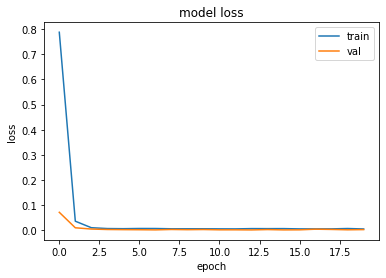

In [99]:
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

From the plot above we can see the losses of both the training and validation data.

In [100]:
# Predicting on our Test data
test_predict=model.predict(test_X)
test_predict.shape, test_y.shape

((3393, 1), (3393,))

In [101]:
### Calculate Root Mean Squared Error (RMSE) performance metrics
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_y,test_predict))
rmse_watts = rmse*1000
print('Test RMSE: %.3f' % rmse+'KW')
print('Test RMSE: %.3f' % rmse_watts+'W')

Test RMSE: 0.050KW
Test RMSE: 49.529W


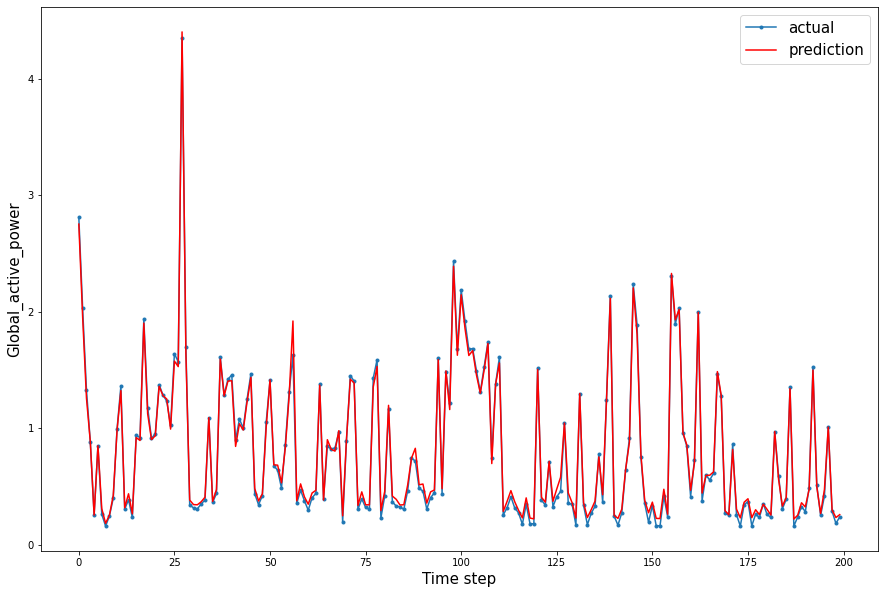

In [180]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.figure(figsize=(15,10))
plt.plot(aa, test_y[:200], marker='.', label="actual")
plt.plot(aa, test_predict[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

The plot shows our actual test values and our prediction values over the first 200 hours on our test data, there is alittle lag behind our actual value, but our model performs really well.

**VISUALISE PREDICTIONS**

Extra Work see our predictions better

In [116]:
val_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2009-09-13 17:00:00,2.758,0.198,239.07,11.4,38.0,1.0,0.0
2009-09-13 18:00:00,1.244,0.000,240.29,5.2,0.0,0.0,19.0
2009-09-13 19:00:00,1.514,0.238,237.95,6.4,0.0,1.0,18.0
2009-09-13 20:00:00,1.636,0.428,238.26,7.0,0.0,0.0,12.0
2009-09-13 21:00:00,3.576,0.182,239.24,15.8,1.0,0.0,18.0


In [105]:
test_value = test_y.reshape((len(test_y), 1))
print(type(test_value))
len(test_value), np.shape(test_value)

<class 'numpy.ndarray'>


(3393, (3393, 1))

In [106]:
# Getting our predictions in 
test_predictions=[]
for i in test_predict:
    test_predictions.append(i)

test_predictions = np.array(test_predictions)
len(test_predictions), type(test_predictions), np.shape(test_predictions)

(3393, numpy.ndarray, (3393, 1))

In [107]:
# Stack the values together and create a pd dataframe
pred_arr = np.hstack((test_value, test_predictions))
pred_df = pd.DataFrame(pred_arr, columns = ['Actual','Predictions'])
pred_df['Validation'] = 0
print(pred_df.head(3))
print(type(pred_df)) 

   Actual  Predictions  Validation
0   2.810     2.752191           0
1   2.028     1.954307           0
2   1.328     1.258606           0
<class 'pandas.core.frame.DataFrame'>


In [108]:
val_value = val_y.reshape((len(val_y), 1))
print(type(val_value))
len(val_value), np.shape(val_value)

<class 'numpy.ndarray'>


(6807, (6807, 1))

In [109]:
df_val = pd.DataFrame(val_value, columns = ['Validation'])
df_val['Actual'] = 0
df_val['Predictions'] = 0
df_val.head(2)

,Validation,Actual,Predictions
0,0.650,0,0
1,0.304,0,0


In [110]:
# Adding the pred df below the val df 
plot_df = df_val.append(pred_df, ignore_index=True)
print(len(plot_df))
plot_df.tail()

10200


,Validation,Actual,Predictions
10195,0.0,0.898,0.901219
10196,0.0,1.096,1.073512
10197,0.0,1.810,1.761840
10198,0.0,1.456,1.467205
10199,0.0,0.938,0.920851


In [111]:
df_hour['hour'] = df_hour.index.strftime('%H')
df_hour['month'] = df_hour.index.strftime('%m')

n = len(df_hour)
t_df = df_hour[0:int(n*0.7)]
v_df = df_hour[int(n*0.7):int(n*0.9)]
tt_df = df_hour[int(n*0.9):]

v_X, v_y = create_data_window(v_df.to_numpy(), 24)
print(v_X.shape, val_y.shape)
print(v_df.values[23][0]) #Same value as below if window is correct
v_y[0]
# v_df.head()

tt_X, tt_y = create_data_window(tt_df.to_numpy(), 24)
print(tt_X.shape, tt_y.shape)
print(tt_df.values[23][0]) #Same value as below if window is correct
tt_y[0]

(6807, 24, 8) (6807,)
0.65
(3393, 24, 8) (3393,)
2.81


2.81

In [112]:
hour = []
month = []
for i in v_X:
    hour.append(i[-1][-2])
    month.append(i[-1][-1])    
# print(len(hour), len(month))
# month[:5], hour[:5]

for i in tt_X:
    hour.append(i[-1][-2])
    month.append(i[-1][-1])    
print(len(hour), len(month))
month[:5], hour[:5]

10200 10200


(['09', '09', '09', '09', '09'], ['16', '17', '18', '19', '20'])

In [113]:
plot_df['hour'] = hour
plot_df['month'] = month
plot_df.head()

,Validation,Actual,Predictions,hour,month
0,0.650,0.0,0.0,16,09
1,0.304,0.0,0.0,17,09
2,0.370,0.0,0.0,18,09
3,3.954,0.0,0.0,19,09
4,2.120,0.0,0.0,20,09


In [154]:
months_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
plot_df['months'] = plot_df['month'].astype(int)
plot_df.info()
month_name = []
for i in plot_df['months']:
    for key, value in months_dict.items():
        if i == key:
            month_name.append(value)
month_name[:5], len(month_name)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Validation   10200 non-null  float64
 1   Actual       10200 non-null  float64
 2   Predictions  10200 non-null  float64
 3   hour         10200 non-null  object 
 4   month        10200 non-null  object 
 5   months       10200 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 478.2+ KB


(['Sep', 'Sep', 'Sep', 'Sep', 'Sep'], 10200)

In [156]:
plot_df['month_name'] = month_name
print(plot_df.info())
plot_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Validation   10200 non-null  float64
 1   Actual       10200 non-null  float64
 2   Predictions  10200 non-null  float64
 3   hour         10200 non-null  object 
 4   month        10200 non-null  object 
 5   months       10200 non-null  int64  
 6   month_name   10200 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 557.9+ KB
None


,Validation,Actual,Predictions,hour,month,months,month_name
0,0.650,0.0,0.0,16,09,9,Sep
1,0.304,0.0,0.0,17,09,9,Sep
2,0.370,0.0,0.0,18,09,9,Sep
3,3.954,0.0,0.0,19,09,9,Sep
4,2.120,0.0,0.0,20,09,9,Sep


In [118]:
# To confirm if the table was set correctly it should have the same values as the one above
v_df.iloc[23]

Global_active_power        0.65
Global_reactive_power     0.128
Voltage                  241.53
Global_intensity            2.8
Sub_metering_1              0.0
Sub_metering_2              2.0
Sub_metering_3              0.0
hour                         16
month                        09
Name: 2009-09-14 16:00:00, dtype: object

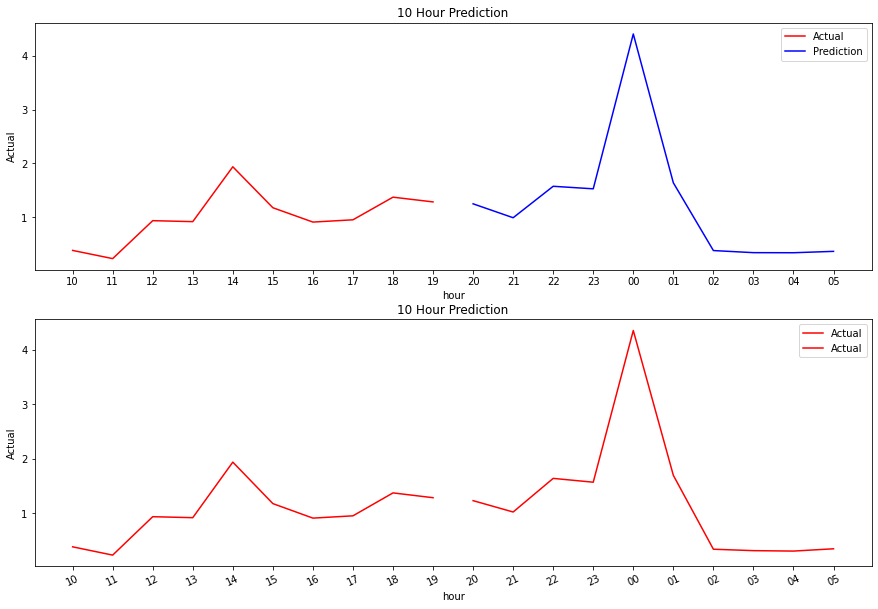

In [181]:
# Predicted values for a span of 10 hours
fig, ax = plt.subplots(2,1, figsize = (15,10))
# Recall the length of of our val and test data, the test data was placed beneath the val data, so we will consider when indexing
sns.lineplot(x=plot_df['hour'][6820:6830], y=plot_df['Actual'][6820:6830], color='r', label='Actual', ax=ax[0])
sns.lineplot(x=plot_df['hour'][6830:6840], y=plot_df['Predictions'][6830:6840], color='b', label='Prediction', ax=ax[0])
plt.xticks(rotation=25)
ax[0].set_title('10 Hour Prediction')
# plt.show()

sns.lineplot(x=plot_df['hour'][6820:6830], y=plot_df['Actual'][6820:6830], color='r', label='Actual', ax=ax[1])
sns.lineplot(x=plot_df['hour'][6830:6840], y=plot_df['Actual'][6830:6840], color='r', label='Actual', ax=ax[1])
plt.xticks(rotation=25)
ax[1].set_title('10 Hour Prediction')
plt.show()

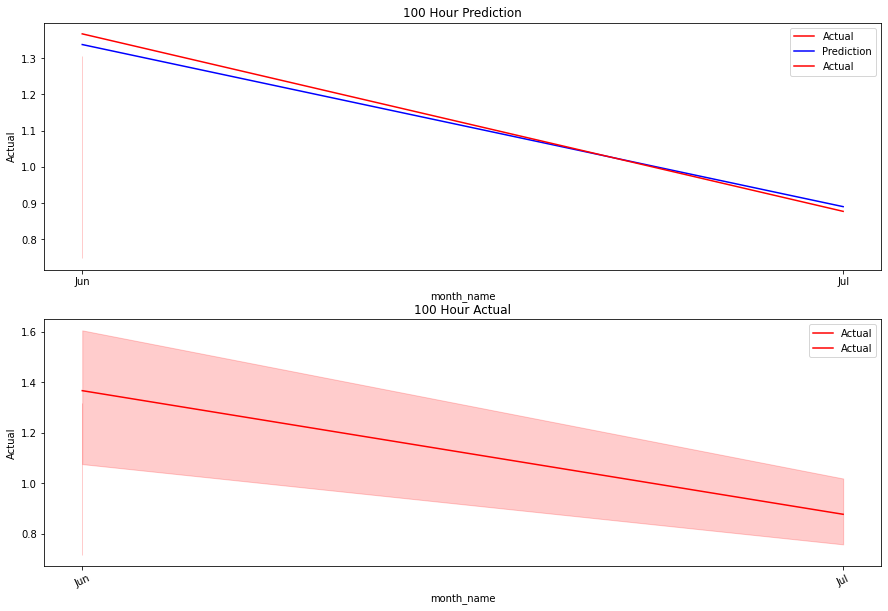

In [183]:
# Predicted values for a span of 100 hours
# Change the axis to month name for better visualisations
fig, ax = plt.subplots(2,1, figsize = (15,10))
# Recall the length of of our val and test data, the test data was placed beneath the val data, so we will consider when indexing
sns.lineplot(x=plot_df['month_name'][6820:6830], y=plot_df['Actual'][6820:6830], color='r', label='Actual', ax=ax[0])
sns.lineplot(x=plot_df['month_name'][6830:6930], y=plot_df['Predictions'][6830:6930], color='b', label='Prediction', ax=ax[0], ci=None)
sns.lineplot(x=plot_df['month_name'][6830:6930], y=plot_df['Actual'][6830:6930], color='r', label='Actual', ax=ax[0], ci=None)

# plt.xticks(rotation=25)
ax[0].set_title('100 Hour Prediction')
# plt.show()

sns.lineplot(x=plot_df['month_name'][6820:6830], y=plot_df['Actual'][6820:6830], color='r', label='Actual', ax=ax[1])
sns.lineplot(x=plot_df['month_name'][6830:6930], y=plot_df['Actual'][6830:6930], color='r', label='Actual', ax=ax[1])
plt.xticks(rotation=25)
ax[1].set_title('100 Hour Actual')
plt.show()

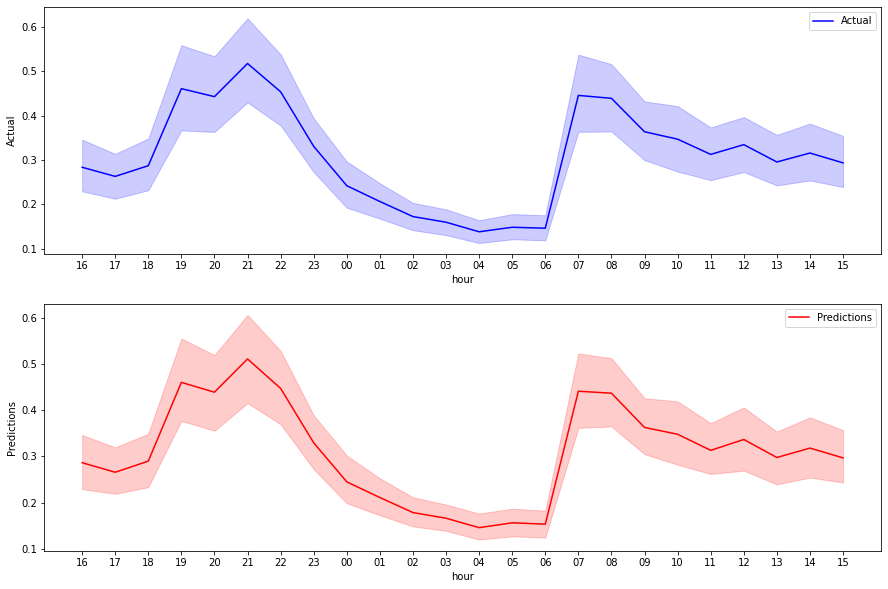

In [184]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
sns.lineplot(x='hour', y='Actual', data=plot_df, color='b', label='Actual',ax=ax[0])
sns.lineplot(x='hour', y='Predictions', data=plot_df, color='r', label='Predictions', ax=ax[1])
# plt.xticks(rotation=25)
plt.show()

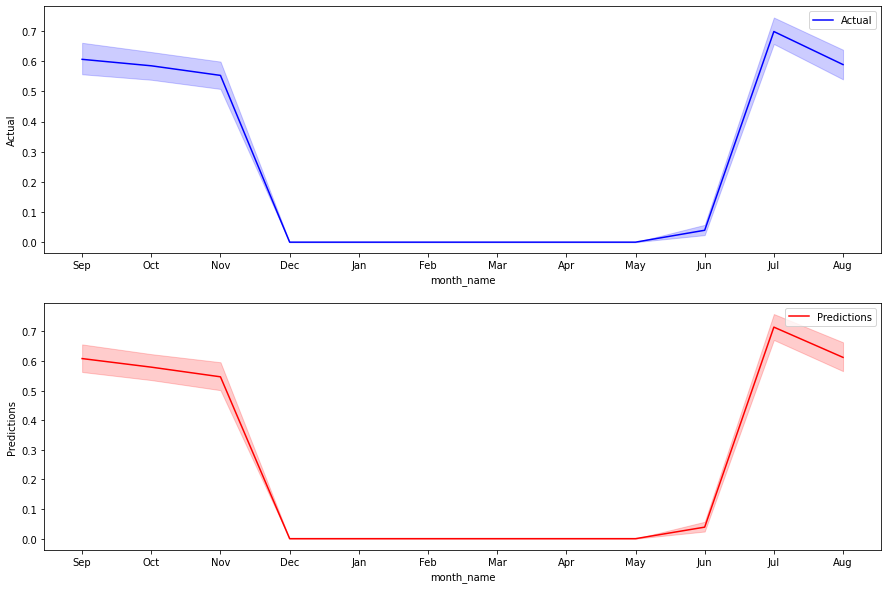

In [186]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
sns.lineplot(x='month_name', y='Actual', data=plot_df, color='b', label='Actual',ax=ax[0])
sns.lineplot(x='month_name', y='Predictions', data=plot_df, color='r', label='Predictions', ax=ax[1])
# plt.xticks(rotation=25)
plt.show()

Recall we added some 0 values to our plot 

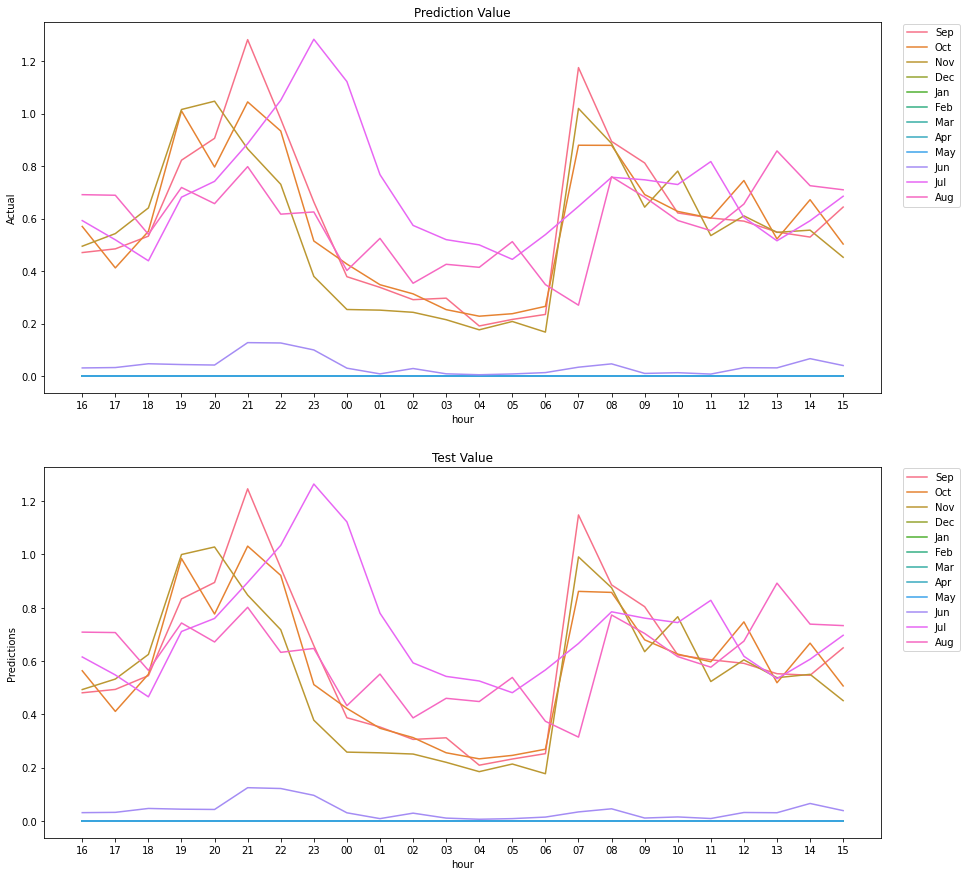

In [178]:
fig, ax = plt.subplots(2,1, figsize=(15,15))
sns.lineplot(x='hour', y='Actual', data=plot_df, hue='month_name',ci=None, ax=ax[0])
ax[0].set_title('Prediction Value')
ax[0].legend(loc='center left', bbox_to_anchor=(1.02, 0.75), ncol=1)
# ax[0].set_xticks(ax[0].get_xticks(), rotation=25)

sns.lineplot(x='hour', y='Predictions', data=plot_df, hue='month_name', ci = None, ax=ax[1])
ax[1].set_title('Test Value')
ax[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.75), ncol=1)
# plt.xticks(rotation=25)
plt.show()

**CONCLUSION**

In the process of our data project:

* we cleaned our data and sampled the data by hour, 
* we also carried out analysis on our data and the insights are documented below the plots. 
* Also we prepared our data by splitting the features and labels, normalizing the features and creating a sliding data window for our LSTM model.
* Finally we built an LSTM model using the tensorflow and keras API or framework and carried out predictions using our model.